# Current effects on stress based on Jeffreys wind input and JONSWAP spectra

In this notebook we explore the form drag distribution with frequency, and effects of currents on stress (form drag, specifically) for JONSWAP spectra of various wind and fetch conditions, assuming a Jeffreys wind input function.

The procedure is:

1. Compute JONSWAP frequency spectra for wind speed of 5, 10, and 15 m/s, and fetch of 1, 10, and 100 km
2. Compute the Jeffreys wind input function to calculate $S_{in}$ and form drag distribution as function of wave frequency
3. Apply opposing and following currents (-1 m/s, 1 m/s) to quantify the effect of currents on stress distribution.

Assumptions and limitations:

1. JONSWAP parametric spectrum
2. Omnidirectional waves
3. Wind aligned with waves
4. Wind input based on Jeffreys (1925), with wind speed evaluated as log-layer average between the surface and half-wavelength
5. Constant sheltering coefficient
6. Depth-uniform current

In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=12)

import numpy as np
from stress_current_interactions.diagnostics import phase_speed
from stress_current_interactions.dispersion import wavenumber
from stress_current_interactions.source_functions import wind_input
from stress_current_interactions.spectral_shapes import jonswap, wavenumber_spectrum
from stress_current_interactions.stress import average_wind_speed_in_log_layer, \
                                               drag_coefficient_LP1981, \
                                               form_drag, wind_speed_at_reference_height, \
                                               friction_velocity_smooth

## Fixed parameters

In [2]:
water_depth = 1e3 # m
rhow = 1e3 # water density [kg/m^3]
grav_accel = 9.8 # m/s^2

## Frequency, wavenumber, and phase speed

In [3]:
f = np.logspace(-1, 2, 100) # frequency range from 0.1 to 100 Hz
k = wavenumber(f, water_depth)
wavelength = 2 * np.pi / k
Cp = phase_speed(f, k)
dk = np.zeros(k.shape)
dk[1:-1] = 0.5 * (k[2:] - k[:-2])
dk[0] = k[1] - k[0]
dk[-1] = k[-1] - k[-2]
Cg = np.zeros(Cp.shape)
Cg[1:] = 2 * np.pi * np.diff(f) / dk[1:]

## Example wave spectra

Let's look at JONSWAP frequency spectra for 3 wind speeds (5, 10, 15 m/s) and 3 fetches (1, 10, 100 km).

$$
S_{\eta\eta}(\omega) = \dfrac{\alpha g^2}{\omega^5} \exp \left[ - \dfrac{5}{4} \left( \dfrac{\omega_p}{\omega} \right)^4 \right] \gamma^r
$$
,
$$
r = \exp \left[ - \dfrac{\left( \omega - \omega_p \right)^2}{2 \sigma^2 \omega_p^2}  \right]
$$
, 
$$
\alpha = 0.076 \left( \dfrac{U_{10}^2}{x g} \right)^{0.22}
$$
,
$$
\omega_p = 22 \left( \dfrac{g^2}{U_{10} x} \right)^{1/3}
$$


where:

* $S_{\eta\eta}$ is the frequency wave spectrum
* $\omega$ is the angular frequency
* $x$ is the fetch (m)
* $U_{10}$ is the 10-m wind speed (m/s)
* $g$ is the gravitational acceleration (m/s$^2$)

JONSWAP is nice because it's:

* Simple to understand and calculate--only 2 input parameters (wind speed and fetch)
* Based on field data, so it's representative of real ocean waves

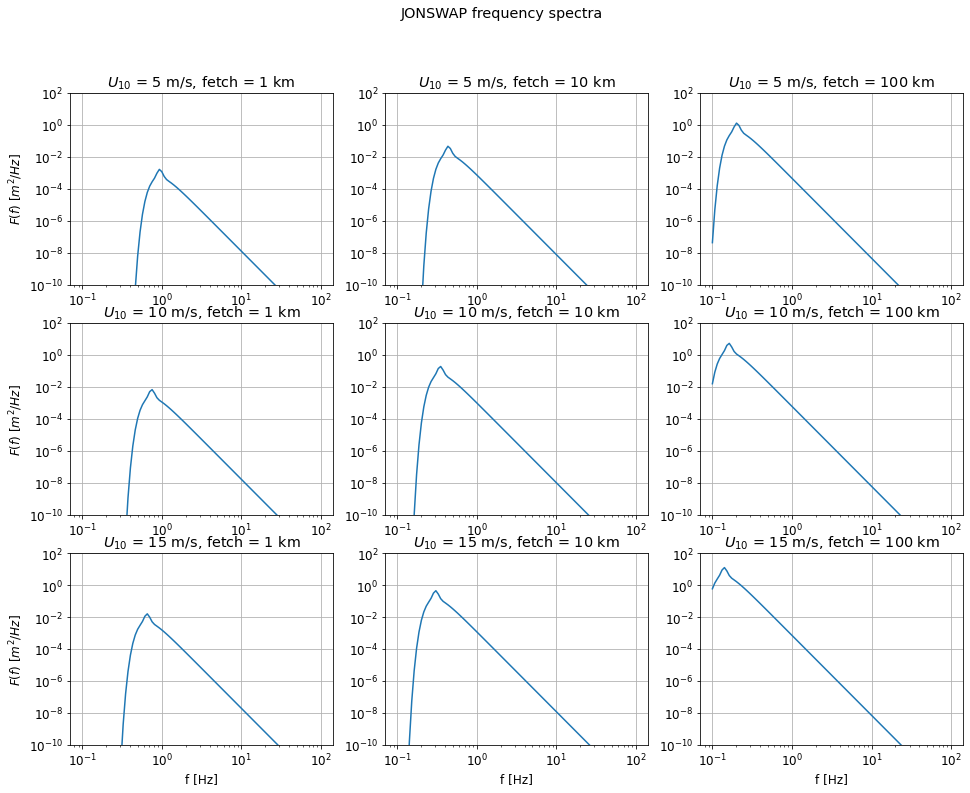

In [4]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle('JONSWAP frequency spectra')
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        ax.loglog(f, jonswap(f, U10, fetch))
        ax.set_ylim(1e-10, 1e2)
        ax.grid()
        if n == 2: ax.set_xlabel('f [Hz]')
        if m == 0: ax.set_ylabel(r'$F(f)$ [$m^2/Hz$]')

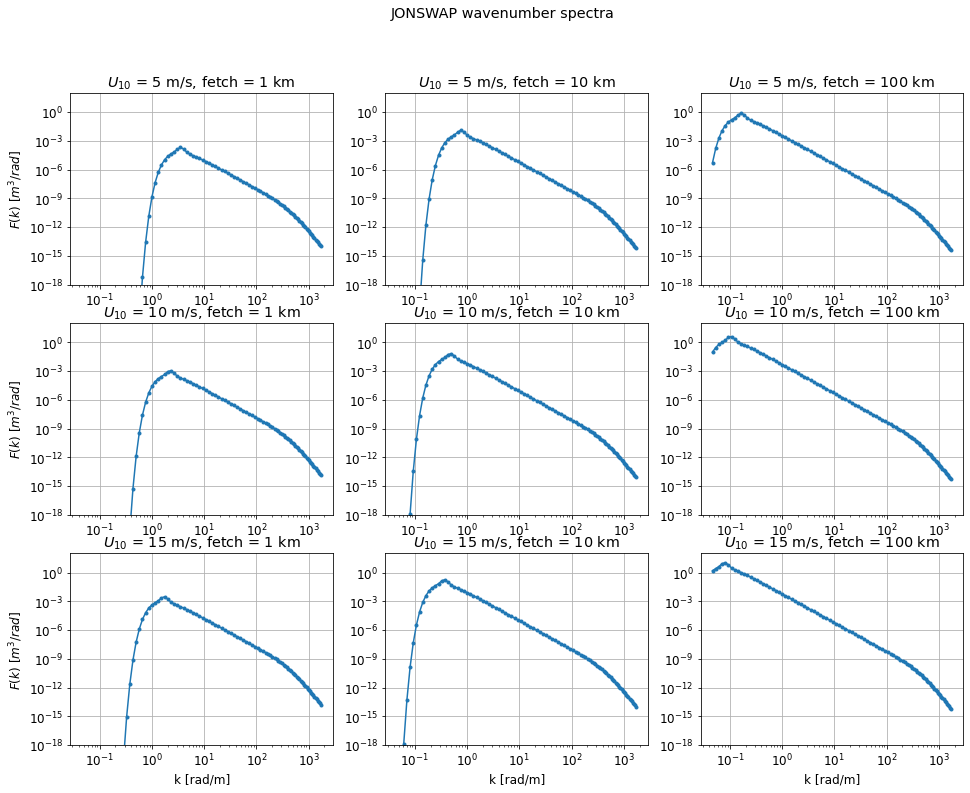

In [5]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle('JONSWAP wavenumber spectra')
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        Ff = jonswap(f, U10, fetch)
        Fk = Ff * Cg / (2 * np.pi)
        ax.loglog(k[1:], Fk[1:], marker='.')
        ax.set_ylim(1e-18, 1e2)
        ax.grid()
        if n == 2: ax.set_xlabel('k [rad/m]')
        if m == 0: ax.set_ylabel(r'$F(k)$ [$m^3/rad$]')

## Given these spectra and some wind, what is wind input like?

$$
S_{in} = \mathcal{A} \dfrac{\rho_a}{\rho_w} \left( U_{\lambda/2} - c_p \right) \left| U_{\lambda/2} - c_p \right| \dfrac{\omega k}{g}
$$

where:

* $\mathcal{A}$ is the sheltering coefficient (assume constant)
* $\rho_a$ and $\rho_w$ are air and water density, respectively
* $U_{\lambda/2}$ is the average wind speed between the surface and half wavelength
* $c_p$ is the phase speed

### Evaluate wind at different heights assuming constant stress (log profile)

Text(0.5, 1.0, '$U_{10} = 10\\ m/s$')

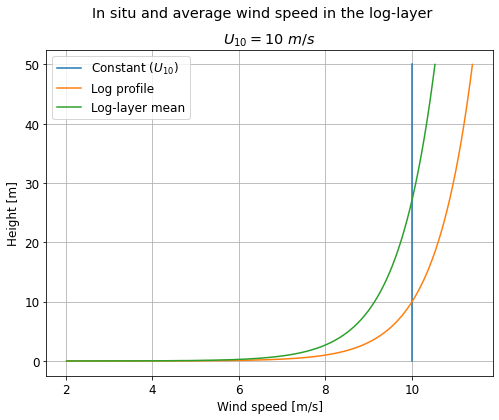

In [6]:
fig = plt.figure(figsize=(8, 6))
z = np.arange(1e-3, 50 + 1e-3, 1e-3)
U10 = 10
ustar = np.sqrt(drag_coefficient_LP1981(U10)) * U10
plt.plot([U10, U10], [0, 50], label=r'Constant ($U_{10}$)')
plt.plot(wind_speed_at_reference_height(U10, 10, ustar, z), z, label='Log profile')
plt.plot(average_wind_speed_in_log_layer(U10, 10, ustar, z), z, label='Log-layer mean')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Height [m]')
plt.grid()
plt.legend()
fig.suptitle('In situ and average wind speed in the log-layer')
plt.title(r'$U_{10} = 10\ m/s$')

In [7]:
def effective_wind_speed(U10: float, z: np.ndarray) -> np.ndarray:
    """Returns effective (log-layer average up to z) wind speed 
    at various heights z, given input U10 and array of heights."""
    ustar = np.sqrt(drag_coefficient_LP1981(U10)) * U10
    U = np.zeros(z.shape)
    for n, zref in enumerate(z):
        zz = np.arange(1e-3, zref + 1e-3, 1e-3) # from 1 mm to zref
        U[n] = average_wind_speed_in_log_layer(U10, 10, ustar, z)[-1]
    return U

## Evaluate wind input for different methods of wind speed--constant U10, at half wavelength, and effective (log-layer average) up to half-wavelength

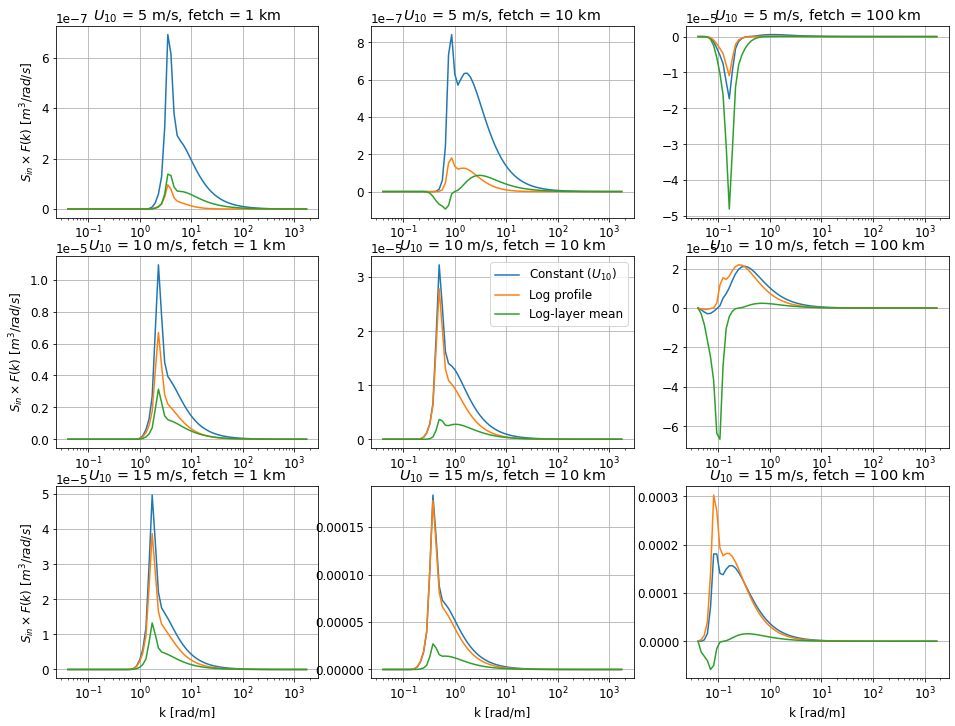

In [8]:
fig = plt.figure(figsize=(16, 12))
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, U10, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        
        U_lambda_half = effective_wind_speed(U10, wavelength / 2)
        
        Sin1 = wind_input(U10, f, k, Cp, current=0)
        Sin2 = wind_input(wind_speed_at_reference_height(U10, 10, ustar, wavelength / 2), f, k, Cp, current=0)
        Sin3 = wind_input(U_lambda_half, f, k, Cp, current=0)
        
        ax.semilogx(k, Sin1 * Fk, label=r'Constant ($U_{10}$)')
        ax.semilogx(k, Sin2 * Fk, label='Log profile')
        ax.semilogx(k, Sin3 * Fk, label='Log-layer mean')
        
        ax.grid()
        if n == 1 and m == 1: ax.legend()
        if n == 2: ax.set_xlabel('k [rad/m]')
        if m == 0: ax.set_ylabel(r'$S_{in} \times F(k)$ [$m^3/rad/s$]')

From here on, I'll assume that the effective wind speed--log-layer average between $z=0$ and $z=\lambda/2$--is the correct forcing.

## What if we consider currents?

Now each wave is Doppler-shifted by the current:

$$
S_{in} = \mathcal{A} \dfrac{\rho_a}{\rho_w} \left( U_{\lambda/2} - c_p - u\right) \left| U_{\lambda/2} - c_p -u\right| \dfrac{\omega k}{g}
$$

For simplicity, this current is depth-uniform and all waves are equally affected by it.

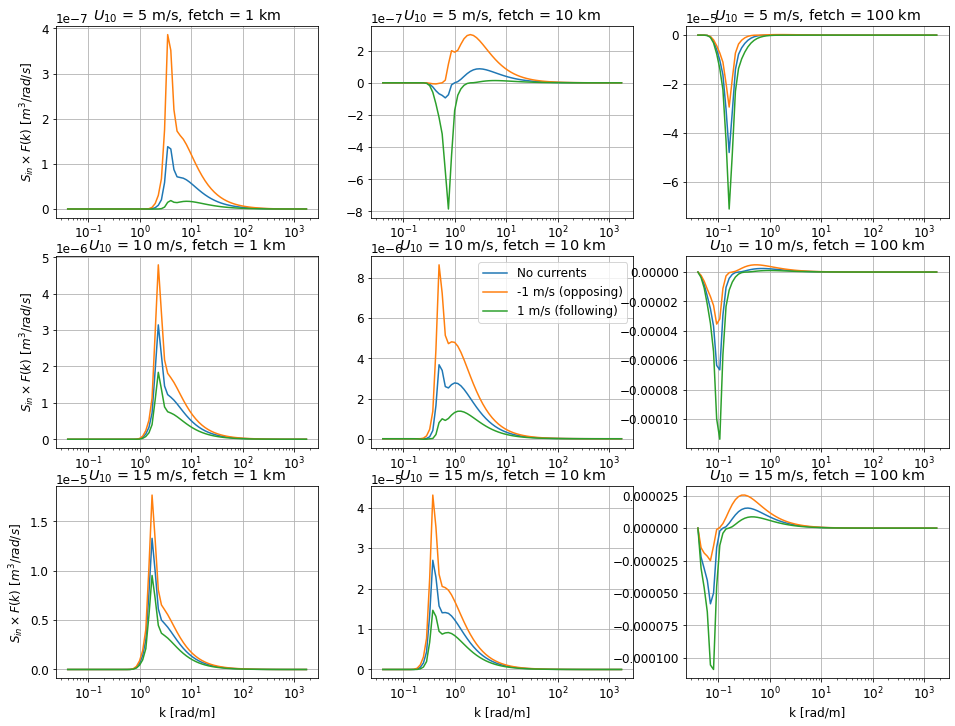

In [9]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['No currents', '-1 m/s (opposing)', '1 m/s (following)']
fig = plt.figure(figsize=(16, 12))
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, U10, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        
        U_lambda_half = effective_wind_speed(U10, wavelength / 2)
        
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(U_lambda_half, f, k, Cp, current=current)
            ax.semilogx(k, Sin * Fk, label=labels[ncol])
            
        ax.grid()
        if n == 2: ax.set_xlabel('k [rad/m]')
        if m == 0: ax.set_ylabel(r'$S_{in} \times F(k)$ [$m^3/rad/s$]')
        if n == 1 and m == 1: plt.legend(loc='upper right')

## How about the stress distribution?

Given wind input function and a wave spectrum, we can calculate the form drag:

$$
\tau = \rho_w g \int \dfrac{S_{in}}{c_p} F(k) dk
$$

where $F(k)$ is the wavenumber spectrum.

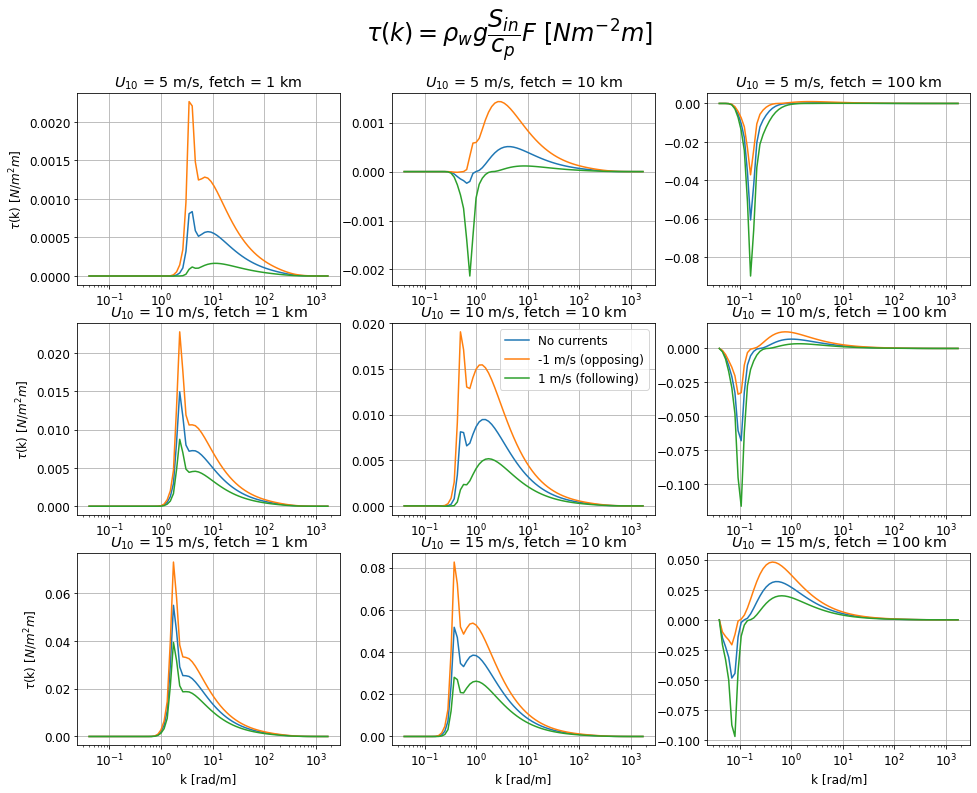

In [10]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['No currents', '-1 m/s (opposing)', '1 m/s (following)']
fig = plt.figure(figsize=(16, 12))
fig.suptitle(r'$\tau(k) = \rho_w g \dfrac{S_{in}}{c_p} F$ [$N m^{-2} m$]', fontsize=24)
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, U10, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        
        U_lambda_half = effective_wind_speed(U10, wavelength / 2)
        
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(U_lambda_half, f, k, Cp, current=current)
            tau = rhow * grav_accel * Sin / Cp * Fk
            ax.semilogx(k, tau, label=labels[ncol])
        ax.grid()
        #ax.set_ylim(1e-12, 1e0)
        if n == 2: ax.set_xlabel('k [rad/m]')
        if m == 0: ax.set_ylabel(r'$\tau$(k) [$N/m^2 m$]')
        if n == 1 and m == 1: plt.legend(loc='upper right')

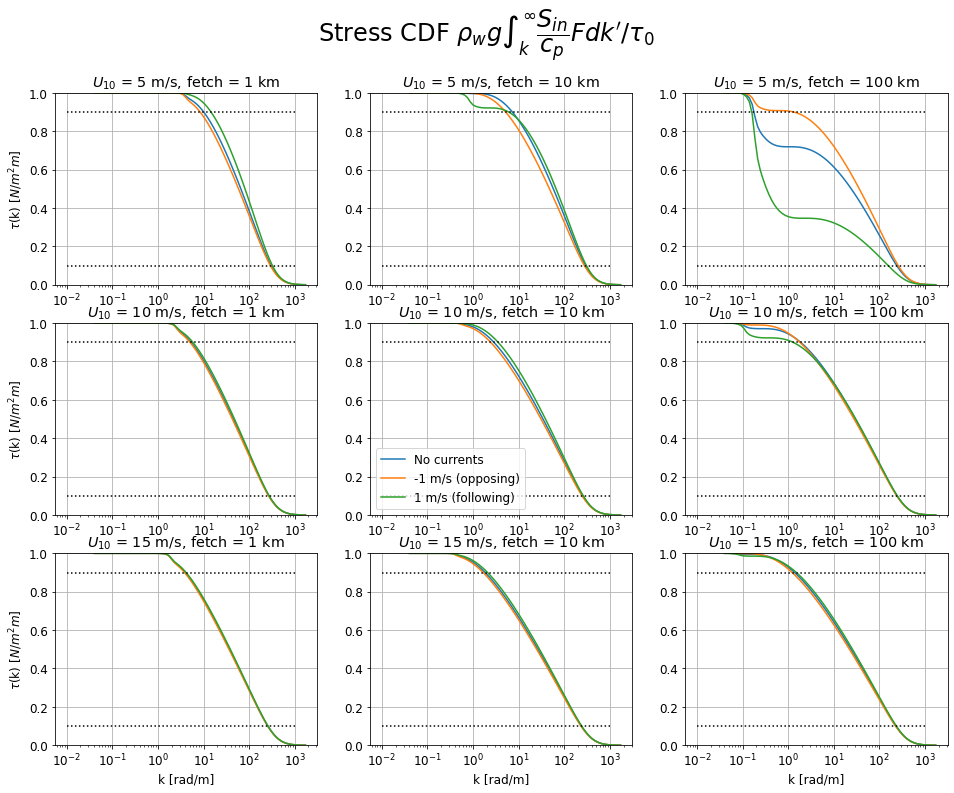

In [11]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['No currents', '-1 m/s (opposing)', '1 m/s (following)']
fig = plt.figure(figsize=(16, 12))
fig.suptitle(r"Stress CDF $\rho_w g \int_k^\infty \dfrac{S_{in}}{c_p} F dk' / \tau_0$", fontsize=24)
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, U10, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        
        U_lambda_half = effective_wind_speed(U10, wavelength / 2)
        
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(U_lambda_half, f, k, Cp, current=current)
            tau_0 = np.sum(rhow * grav_accel * np.abs(Sin) / Cp * Fk * dk)
            tau = np.cumsum((rhow * grav_accel * np.abs(Sin) / Cp * Fk * dk)[::-1]) / tau_0
            ax.semilogx(k[::-1], tau, label=labels[ncol])
        ax.grid()
        ax.set_ylim(0, 1)
        plt.plot([1e-2, 1e3], [0.1, 0.1], 'k:')
        plt.plot([1e-2, 1e3], [0.9, 0.9], 'k:')
        if n == 2: ax.set_xlabel('k [rad/m]')
        if m == 0: ax.set_ylabel(r'$\tau$(k) [$N/m^2 m$]')
        if n == 1 and m == 1: plt.legend(loc='lower left')

## The weighing function $\varphi(k)$

Finally, the weighing function is the normalized stress distribution:

$$
\varphi(k) = \dfrac{\dfrac{S_{in}}{C_p} F(k)}{\int_0^\infty \dfrac{S_{in}}{C_p} F(k) dk}
$$

Such that its integral over $dk$ is 1:

$$
\int \varphi(k) dk = 1
$$

I will ignore current effects here for simplicity.

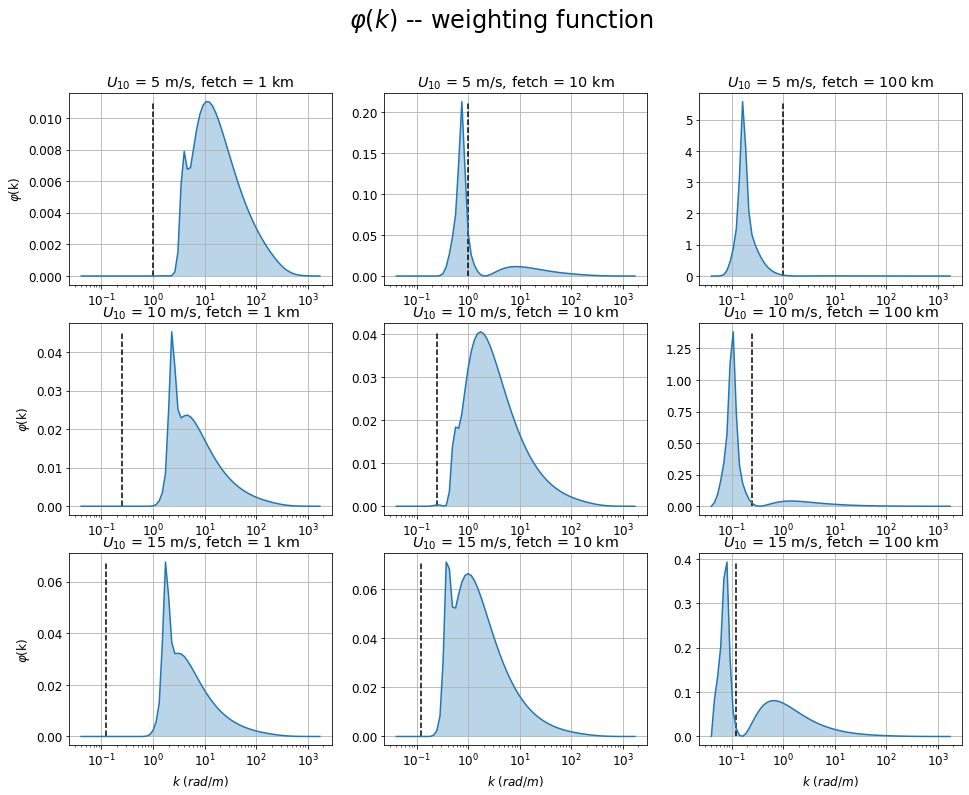

In [12]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle(r'$\varphi(k)$ -- weighting function', fontsize=24)
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, U10, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        
        U_lambda_half = effective_wind_speed(U10, wavelength / 2)
        
        Sin = wind_input(U_lambda_half, f, k, Cp, current=current)
        tau_k = np.abs(rhow * grav_accel * Sin / Cp * Fk)
        tau_0 = np.sum(tau_k * dk)
        
        k0 = k[np.argmin((U_lambda_half - Cp)**2)]
        tau_max = np.nanmax(tau_k / tau_0)
        plt.plot([k0, k0], [0, tau_max], 'k--')
        
        ax.semilogx(k, tau_k / tau_0)
        ax.fill_between(k, tau_k / tau_0, alpha=0.3)
        ax.grid()
        if n == 2: ax.set_xlabel(r'$k\ (rad/m)$')
        if m == 0: ax.set_ylabel(r'$\varphi$(k)')

## Weighting function, plotted as equal-area

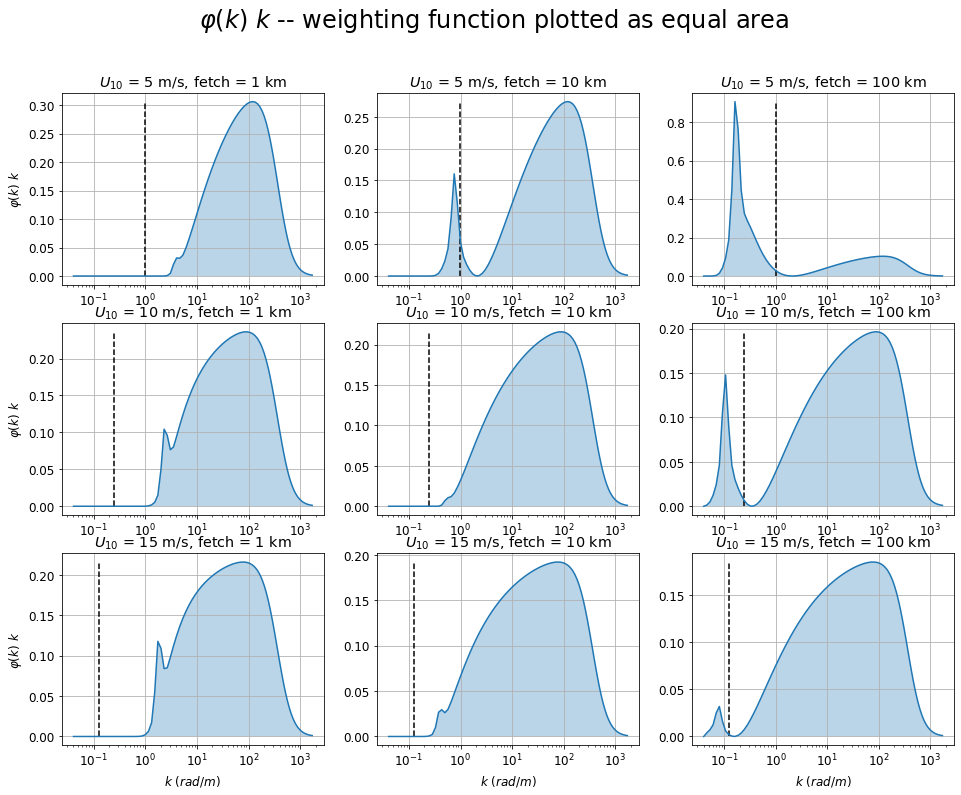

In [13]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle(r'$\varphi(k) \ k$ -- weighting function plotted as equal area', fontsize=24)
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, U10, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        
        U_lambda_half = effective_wind_speed(U10, wavelength / 2)
        
        Sin = wind_input(U_lambda_half, f, k, Cp, current=current)
        tau_k = np.abs(rhow * grav_accel * Sin / Cp * Fk)
        tau_0 = np.sum(tau_k * dk)
        
        k0 = k[np.argmin((U_lambda_half - Cp)**2)]
        tau_max = np.nanmax(tau_k / tau_0 * k)
        plt.plot([k0, k0], [0, tau_max], 'k--')
        
        ax.semilogx(k, tau_k / tau_0 * k)
        ax.fill_between(k, tau_k / tau_0 * k, alpha=0.3)
        ax.grid()
        if n == 2: ax.set_xlabel(r'$k\ (rad/m)$')
        if m == 0: ax.set_ylabel(r'$\varphi(k) \ k$')

## Stress change due to currents relative to no currents

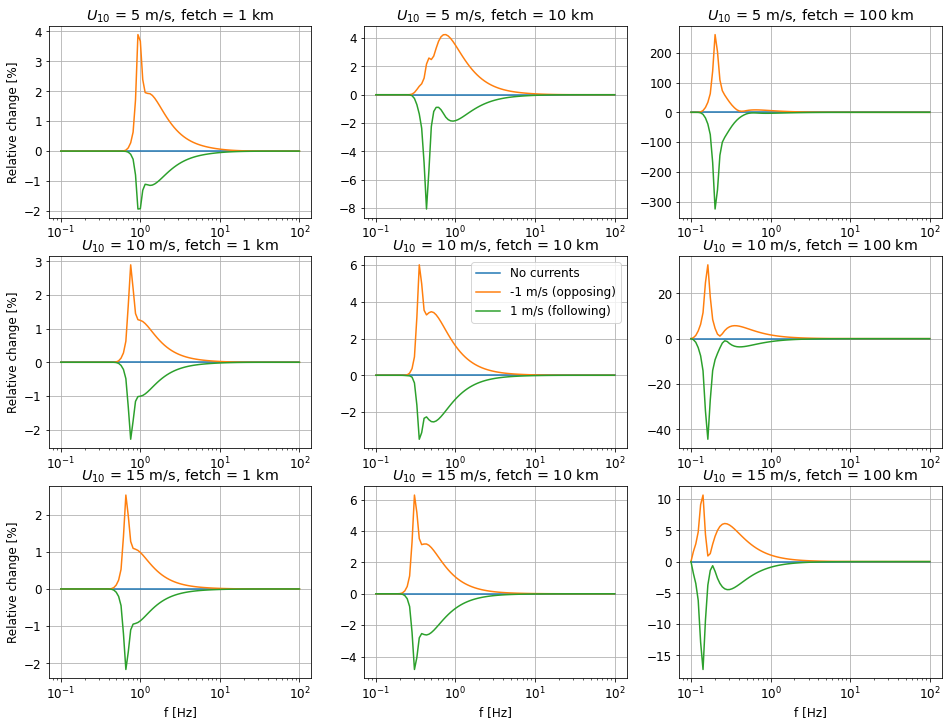

In [14]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['No currents', '-1 m/s (opposing)', '1 m/s (following)']
fig = plt.figure(figsize=(16, 12))
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title(r'$U_{10}$ = %i m/s' % U10 + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, U10, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        
        U_lambda_half = effective_wind_speed(U10, wavelength / 2)
        
        Sin = wind_input(U_lambda_half, f, k, Cp, current=0)
        tau0 = rhow * grav_accel * Sin / Cp * Fk
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(U_lambda_half, f, k, Cp, current=current)
            tau = rhow * grav_accel * Sin / Cp * Fk
            ax.semilogx(f, 100 * (tau - tau0) / np.sum(tau0[1:] * np.diff(k)), label=labels[ncol])
        ax.grid()
        if n == 2: ax.set_xlabel('f [Hz]')
        if m == 0: ax.set_ylabel('Relative change [%]')
        if n == 1 and m == 1: plt.legend(loc='upper right')

## Form drag as function of wind speed, fetch, and current

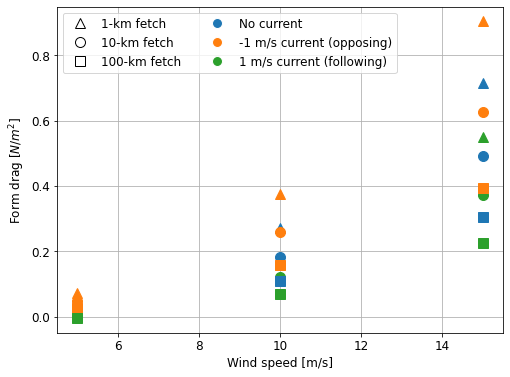

In [15]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
markers = ['^', 'o', 's']
fig = plt.figure(figsize=(8, 6))
for n, U10 in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        F = jonswap(f, U10, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        U_lambda_half = effective_wind_speed(U10, wavelength / 2)
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(U_lambda_half, f, k, Cp, current=current)
            tau = form_drag(Sin, Fk, Cp, k)
            plt.plot(U10, tau, color=colors[ncol], marker=markers[m], ms=10)
plt.grid()
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Form drag [$N/m^2$]')
plt.plot(np.nan, np.nan, linestyle='', mfc='w', mec='k', marker='^', ms=10, label='1-km fetch')
plt.plot(np.nan, np.nan, linestyle='', mfc='w', mec='k', marker='o', ms=10, label='10-km fetch')
plt.plot(np.nan, np.nan, linestyle='', mfc='w', mec='k', marker='s', ms=10, label='100-km fetch')
plt.plot(np.nan, np.nan, linestyle='', mfc='tab:blue', mec='w', marker='o', ms=10, label='No current')
plt.plot(np.nan, np.nan, linestyle='', mfc='tab:orange', mec='w', marker='o', ms=10, label='-1 m/s current (opposing)')
plt.plot(np.nan, np.nan, linestyle='', mfc='tab:green', mec='w', marker='o', ms=10, label='1 m/s current (following)')
plt.legend(ncol=2)